# **TPI: DATA SCIENCE**
### **Grupo 8 : Guillermina Ara | Melanie Solipaca | Fernando Müller**
# Predicción de Satisfacción de Pasajeros en Aerolíneas

En este trabajo práctico se abordará un problema de clasificación binaria utilizando un dataset que contiene evaluaciones de pasajeros sobre su experiencia en vuelos de aerolíneas.

El objetivo es desarrollar un modelo de machine learning que permita **predecir si un pasajero está satisfecho o no**, en base a distintos factores como:

- Tipo de viaje (`Type of Travel`)
- Clase del boleto (`Class`)
- Comodidad del asiento (`Seat comfort`)
- Servicio de WiFi a bordo (`Inflight wifi service`)
- Proceso de embarque online (`Online boarding`)
- Retrasos en salida o llegada (`Departure/Arrival Delay in Minutes`)

Este tipo de solución es útil para aerolíneas que buscan mejorar la experiencia del cliente, identificar puntos críticos en sus servicios y anticiparse a malas experiencias mediante alertas o intervenciones proactivas.

## EDA (Exploratory Data Analysis)

In [50]:
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


from scipy.stats import chi2_contingency
from pandas.api.types import CategoricalDtype
from IPython.display import display
from itertools import combinations

# Configuracion global de graficos
sns.set(style="whitegrid")
plt.style.use("ggplot")

In [51]:
# Cargar el dataset
df = pd.read_csv("Invistico_Airline.csv")

# Mostrar las primeras filas
df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


### Información general del dataset

Este paso permite obtener una visión general de la estructura del dataset:

- Cantidad total de registros y columnas
- Nombre de cada columna
- Cantidad de valores no nulos por columna
- Tipo de dato de cada columna (`object`, `int64`, `float64`, etc.)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

### Análisis de valores nulos

Este paso permite identificar columnas que tienen datos faltantes (valores nulos) en el dataset.  
Esto es importante para decidir si los eliminamos, los imputamos o aplicamos algún otro tratamiento antes del modelado.

In [53]:
df.isnull().sum().sort_values(ascending=False)

Arrival Delay in Minutes             393
Inflight entertainment                 0
Departure Delay in Minutes             0
Online boarding                        0
Cleanliness                            0
Checkin service                        0
Baggage handling                       0
Leg room service                       0
On-board service                       0
Ease of Online booking                 0
Online support                         0
satisfaction                           0
Gender                                 0
Gate location                          0
Food and drink                         0
Departure/Arrival time convenient      0
Seat comfort                           0
Flight Distance                        0
Class                                  0
Type of Travel                         0
Age                                    0
Customer Type                          0
Inflight wifi service                  0
dtype: int64

### Análisis y tratamiento de valores nulos en **Arrival Delay in Minutes**

En la celda anterior de código, se detectó que la columna `Arrival Delay in Minutes` contiene **393 valores nulos**, que representa aproximadamente un **0.3% del total del dataset (129.880 registros)**.

Dado que esta variable puede aportar información valiosa al modelo de predicción de satisfacción (por ejemplo, se espera que los pasajeros con mayores retrasos estén más insatisfechos), **no se eliminó** directamente, sino que se evaluaron opciones de imputación.

La imputación consiste en reemplazar los valores faltantes por un valor estimado mediante alguna estrategia como:

- **Media**: cuando la variable tiene una distribución simétrica y sin valores extremos.
- **Mediana**: preferible cuando hay valores atípicos o una distribución sesgada, ya que es más robusta frente a outliers.

#### Distribución de la variable

Para tomar una decisión informada, se analizó la distribución de la variable mediante un histograma con curva de densidad.

In [54]:
# Estadísticas básicas para observar media, mediana y valores extremos
df['Arrival Delay in Minutes'].describe()

count    129487.000000
mean         15.091129
std          38.465650
min           0.000000
25%           0.000000
50%           0.000000
75%          13.000000
max        1584.000000
Name: Arrival Delay in Minutes, dtype: float64

In [55]:
print(f"median: {df['Arrival Delay in Minutes'].median()}")

median: 0.0


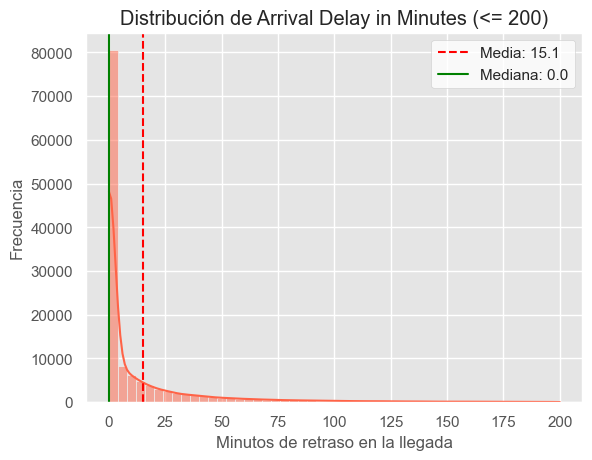

In [56]:
# Histograma truncado (hasta 200 minutos) para mejorar la visualización
sns.histplot(df[df['Arrival Delay in Minutes'] <= 200]['Arrival Delay in Minutes'],
             kde=True, bins=50, color='tomato')

# Calcular media y mediana
mean_val = df['Arrival Delay in Minutes'].mean()
median_val = df['Arrival Delay in Minutes'].median()

# Dibujar líneas verticales
plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.1f}')

legend = plt.legend()
legend.get_frame().set_facecolor('white')

plt.title("Distribución de Arrival Delay in Minutes (<= 200)")
plt.xlabel("Minutos de retraso en la llegada")
plt.ylabel("Frecuencia")
plt.show()

#### Interpretación

Al observar el gráfico y la información, se puede notar que:

- **Mediana (50%)**: 0.0 → la mayoría de los vuelos **no tiene retrasos**
- **Media**: 15.1 minutos → afectada por outliers (retrasos muy altos)
- **Máximo**: 1584 minutos → valor extremadamente alto
- **Desviación estándar**: 38.5 → alta dispersión

Entonces,
- La mayoría de los retrasos está concentrada entre 0 y 10 minutos.
- Existen outliers importantes, con valores superiores a 1000 minutos.
- La distribución es claramente sesgada a la derecha.

Dado el comportamiento de la variable, se decidió imputar los valores nulos utilizando la **mediana**, por ser una medida representativa del "retraso típico" y menos sensible a valores extremos.

Este tratamiento permite conservar esos registros en el dataset sin introducir distorsiones estadísticas significativas.


In [57]:
# Imputación de los valores nulos con la mediana (0.0)
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())

In [58]:
df.isnull().sum().sort_values(ascending=False)

satisfaction                         0
Inflight entertainment               0
Departure Delay in Minutes           0
Online boarding                      0
Cleanliness                          0
Checkin service                      0
Baggage handling                     0
Leg room service                     0
On-board service                     0
Ease of Online booking               0
Online support                       0
Inflight wifi service                0
Gender                               0
Gate location                        0
Food and drink                       0
Departure/Arrival time convenient    0
Seat comfort                         0
Flight Distance                      0
Class                                0
Type of Travel                       0
Age                                  0
Customer Type                        0
Arrival Delay in Minutes             0
dtype: int64

#### Aplicación de imputación

Se imputaron los 393 valores nulos en la columna `Arrival Delay in Minutes` utilizando la **mediana** (0.0).  
Como mencionado anteriormente, esto permite conservar los registros sin introducir sesgo causado por valores extremos.

Se verificó que ya no quedan valores faltantes en esta columna.

### Análisis de la variable objetivo: `satisfaction`

La variable objetivo de este proyecto es `satisfaction`, que indica si el pasajero quedó **satisfecho** o **insatisfecho** con su experiencia en el vuelo.

Para comenzar el análisis, se evaluó la distribución de clases para verificar si el dataset está balanceado.

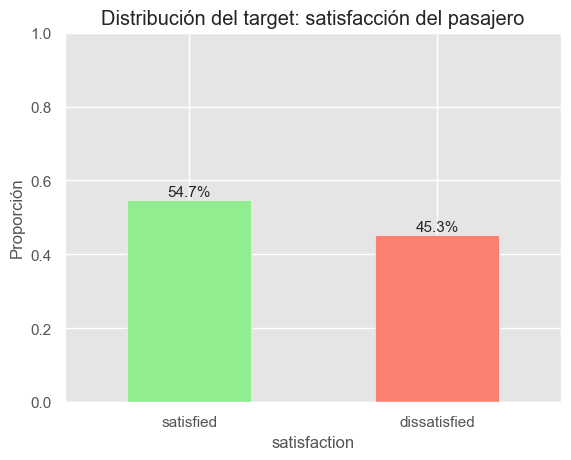

In [59]:
# Distribución de la variable objetivo (satisfaction)
proporciones = df['satisfaction'].value_counts(normalize=True)

ax = proporciones.plot(kind='bar', color=['lightgreen', 'salmon'])
plt.title("Distribución del target: satisfacción del pasajero")
plt.ylabel("Proporción")
plt.xticks(rotation=0)

# Agregar porcentajes sobre las barras
for i, valor in enumerate(proporciones):
    plt.text(i, valor + 0.01, f"{valor:.1%}", ha='center', fontsize=11)

plt.ylim(0, 1)  # para asegurar que los textos no se corten
plt.show()

#### Resultados:

- **54.7%** de los pasajeros están **satisfechos**
- **45.3%** están **insatisfechos**

La distribución está relativamente balanceada, pero es mayor el numero de pasajeros satisfechos que insatisfechos.

# Análisis de variables predictoras

Ya explorada la variable objetivo (`satisfaction`), analizamos las variables predictoras que podrían ayudarnos a anticipar si un pasajero estará satisfecho o no con su experiencia de vuelo.

Para esto, dividimos las variables en:

- **Variables cualitativas**
- **Variables cuantitativas**




### Variables cualitativas

- `Gender`
- `Customer Type`
- `Type of Travel`
- `Class`
- `Inflight wifi service`
- `Departure/Arrival time convenient`
- `Ease of Online booking`
- `Gate location`
- `Food and drink`
- `Online boarding`
- `Seat comfort`
- `Inflight entertainment`
- `On-board service`
- `Leg room service`
- `Baggage handling`
- `Checkin service`
- `Cleanliness`
- `Online support`

Algunas variables, aunque están codificadas numéricamente, representan niveles categoricos y se analizan como cualitativas.


### Visualización de la relación con `satisfaction`

Para analizar la relación entre estas variables y la satisfacción del pasajero, utilizamos gráficos de barras agrupados (`countplot`). En cada gráfico, se muestra la distribución de pasajeros satisfechos e insatisfechos dentro de cada categoría. Además, se incorporaron heatmaps de frecuencias absolutas, que permiten identificar visualmente las combinaciones más frecuentes entre cada categoría y el nivel de satisfacción.

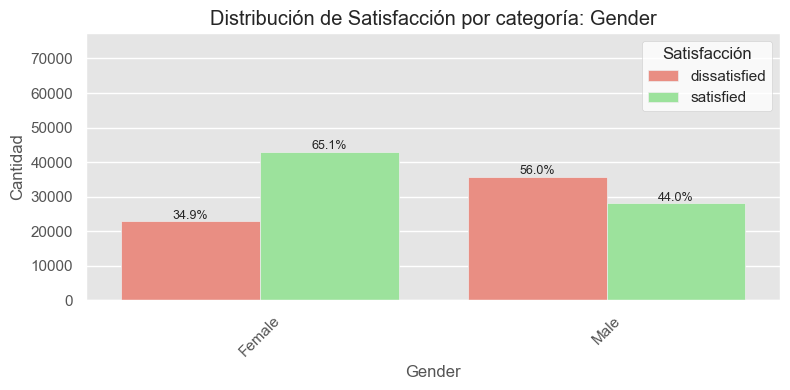

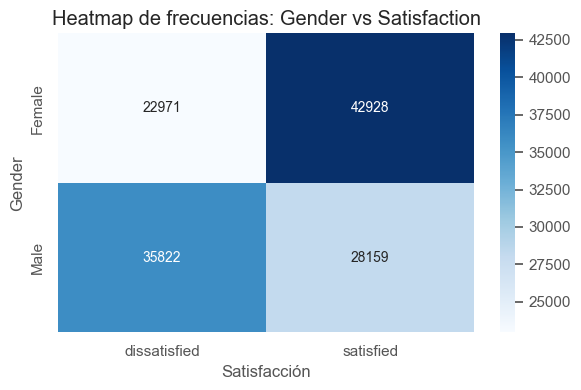


------------------------------------------------------------------------------------------------------------------------



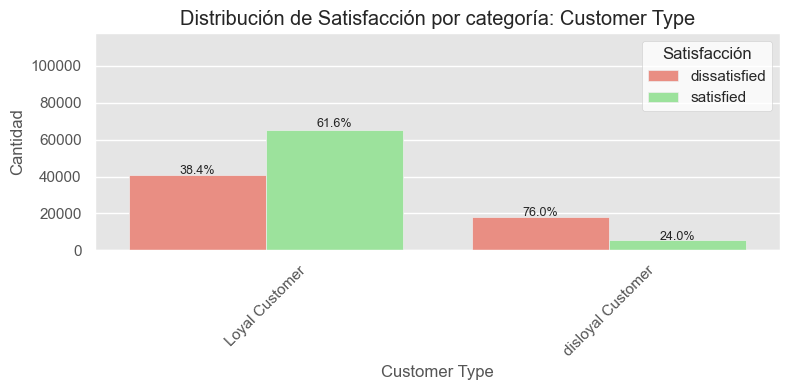

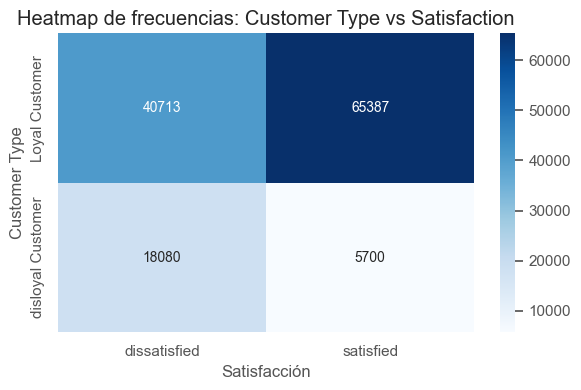


------------------------------------------------------------------------------------------------------------------------



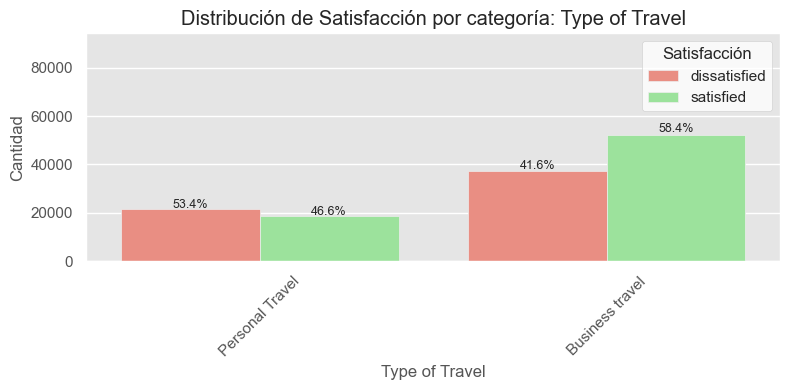

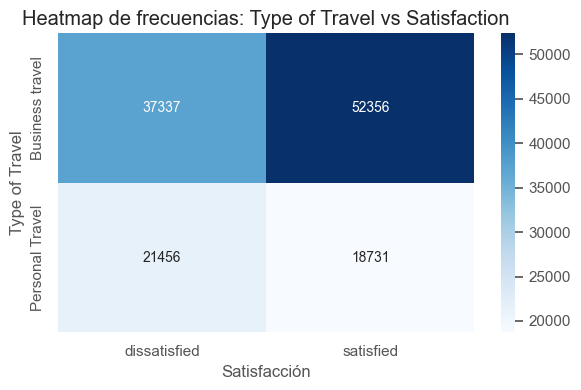


------------------------------------------------------------------------------------------------------------------------



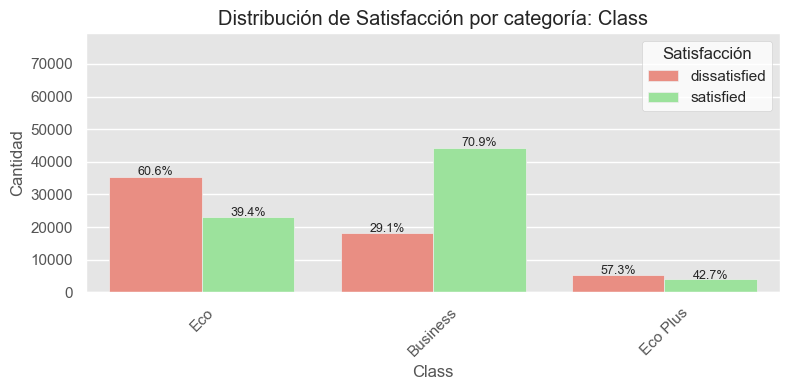

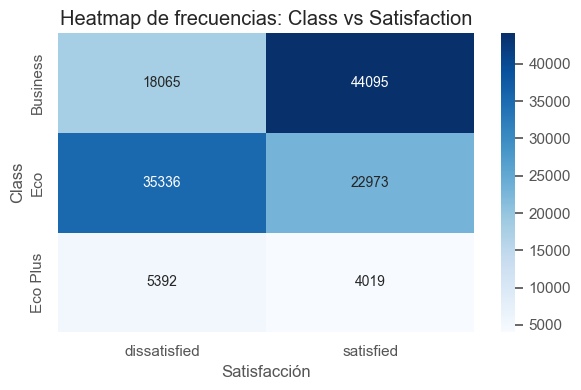


------------------------------------------------------------------------------------------------------------------------



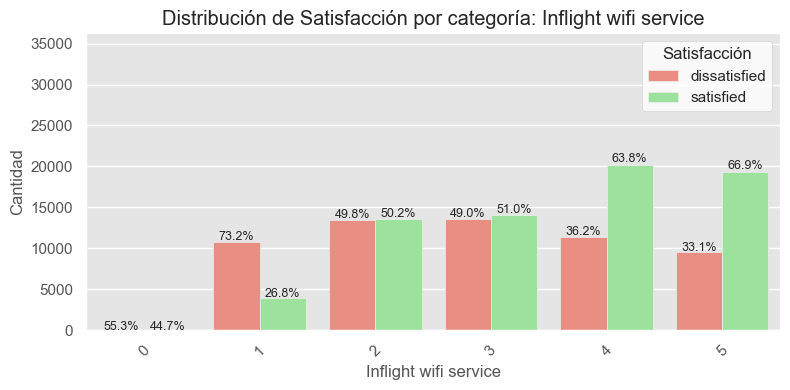

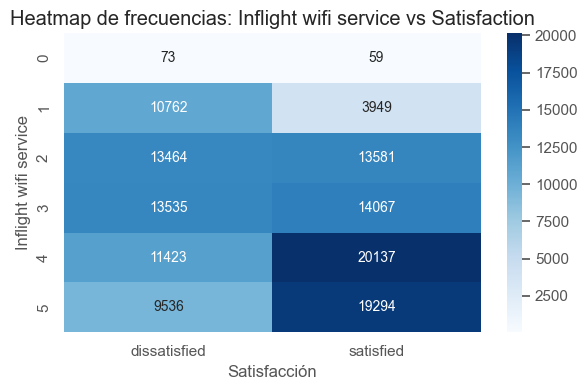


------------------------------------------------------------------------------------------------------------------------



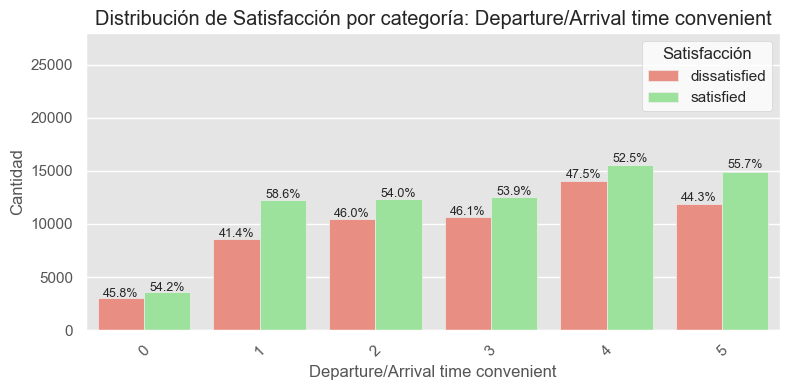

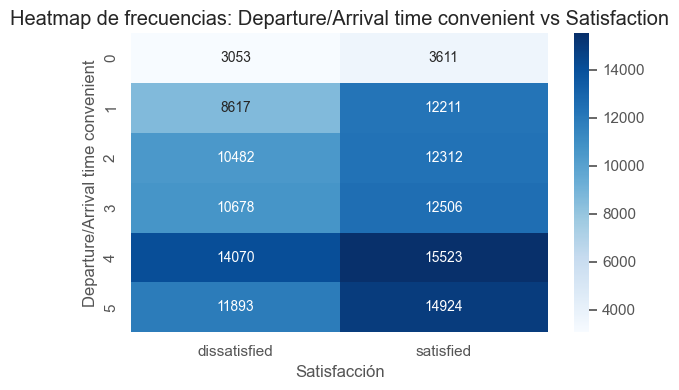


------------------------------------------------------------------------------------------------------------------------



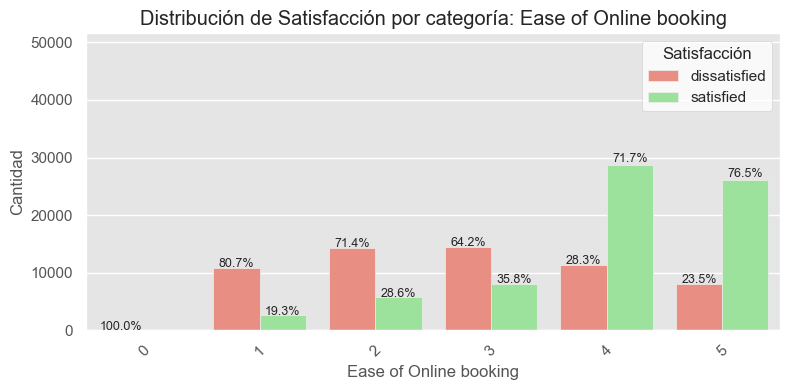

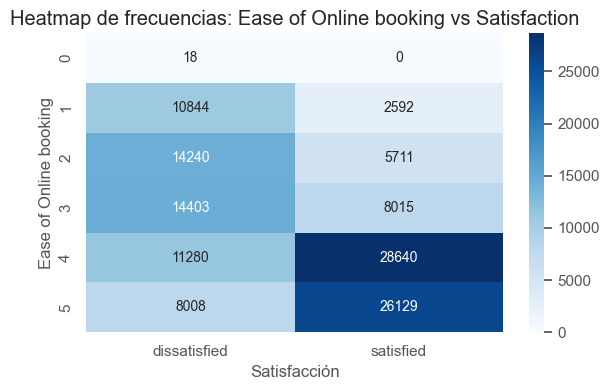


------------------------------------------------------------------------------------------------------------------------



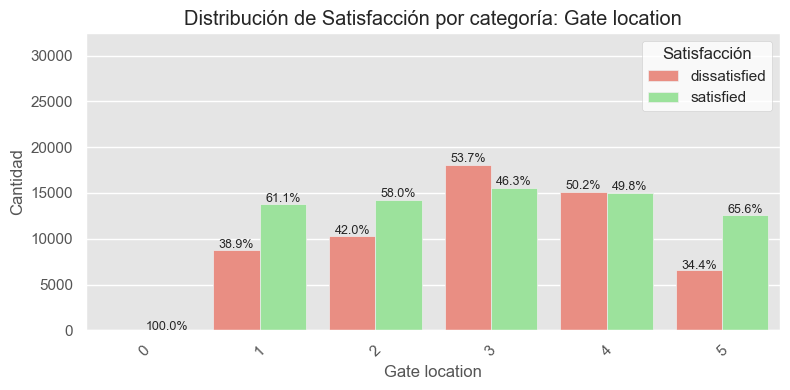

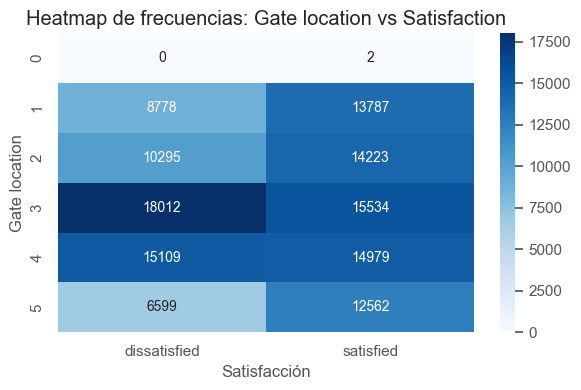


------------------------------------------------------------------------------------------------------------------------



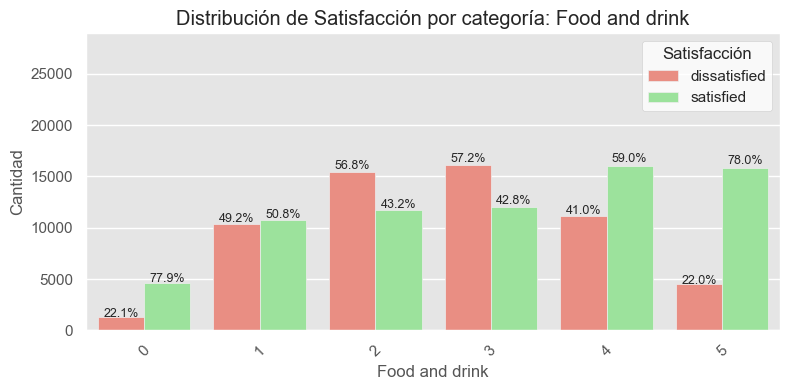

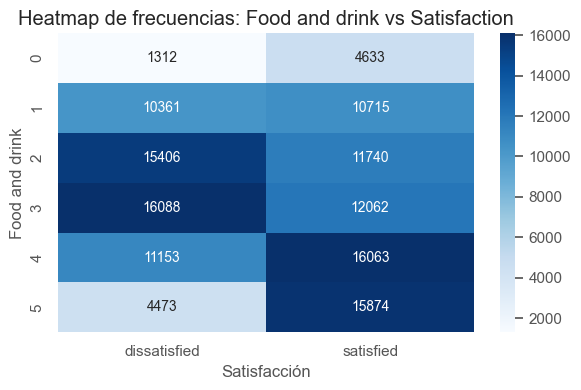


------------------------------------------------------------------------------------------------------------------------



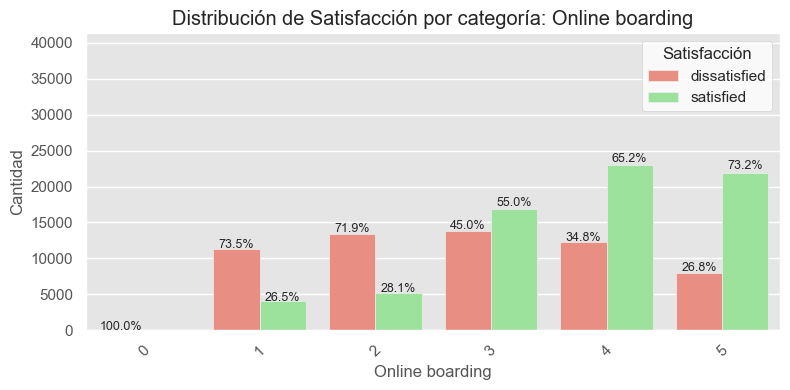

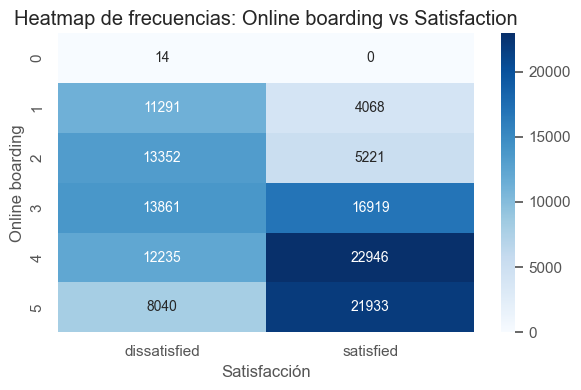


------------------------------------------------------------------------------------------------------------------------



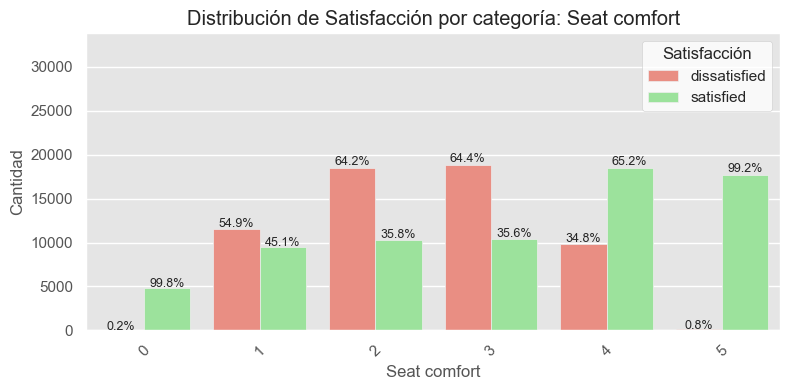

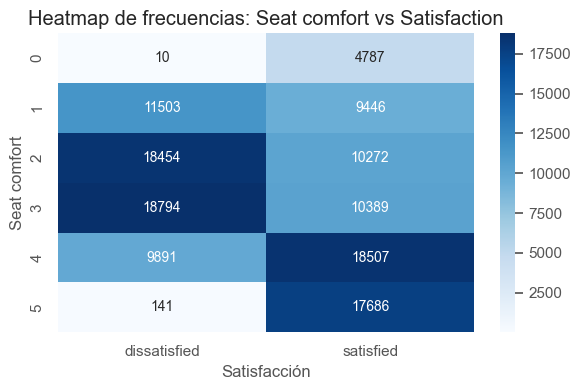


------------------------------------------------------------------------------------------------------------------------



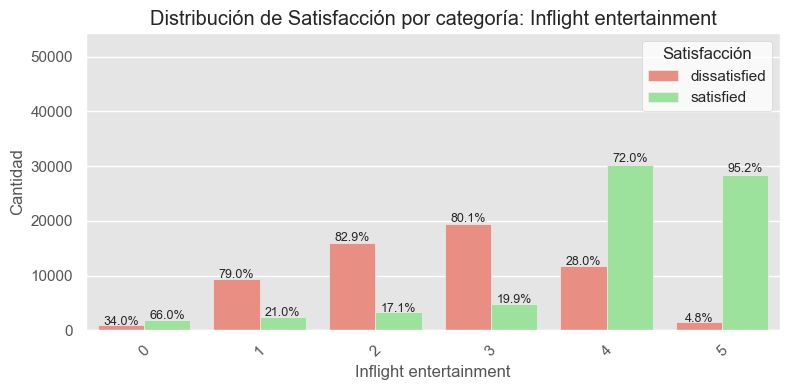

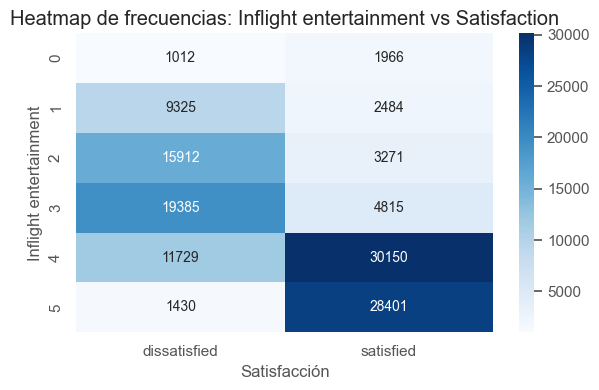


------------------------------------------------------------------------------------------------------------------------



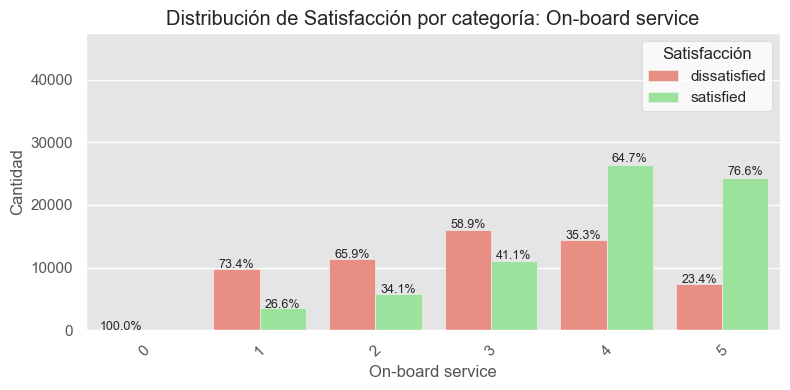

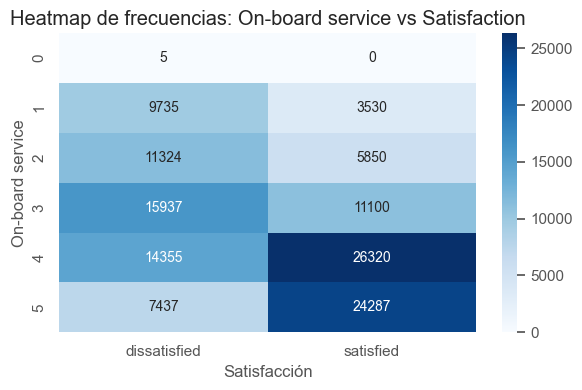


------------------------------------------------------------------------------------------------------------------------



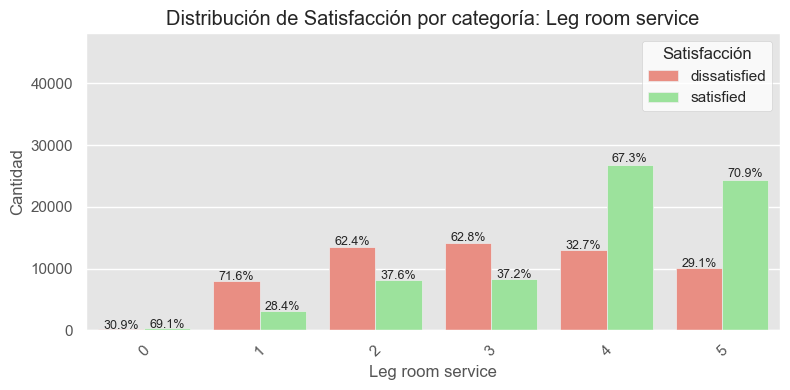

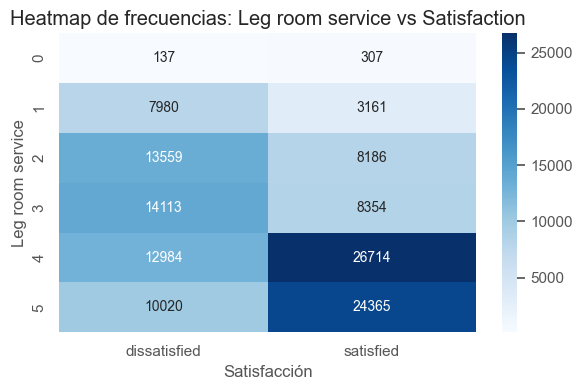


------------------------------------------------------------------------------------------------------------------------



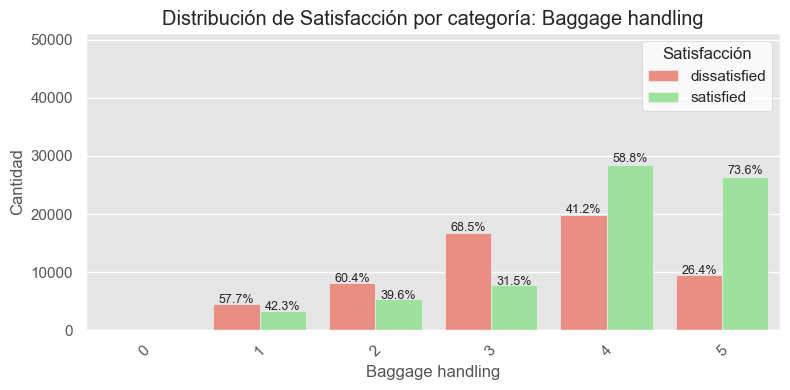

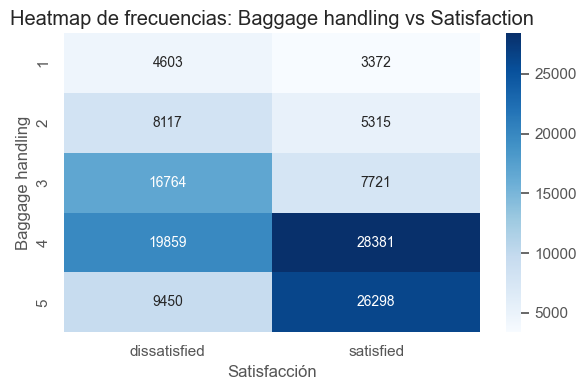


------------------------------------------------------------------------------------------------------------------------



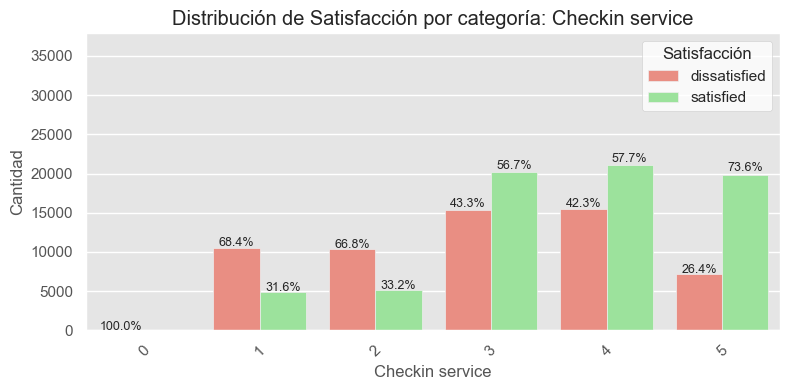

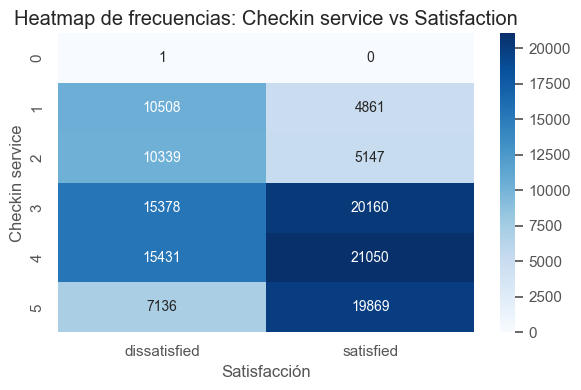


------------------------------------------------------------------------------------------------------------------------



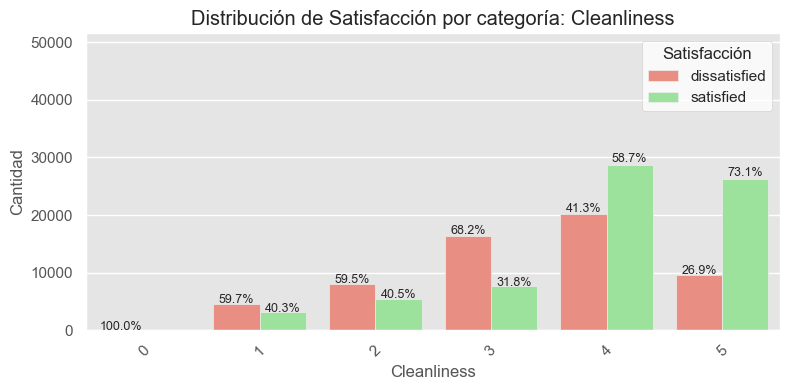

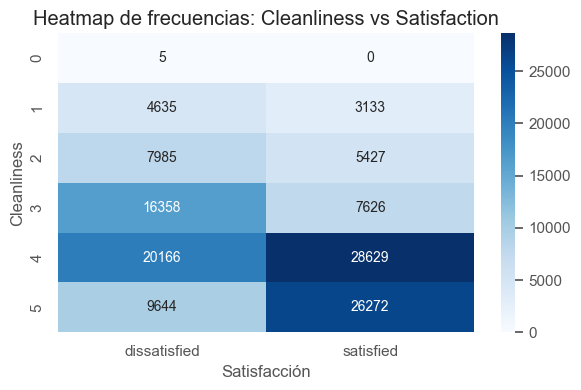


------------------------------------------------------------------------------------------------------------------------



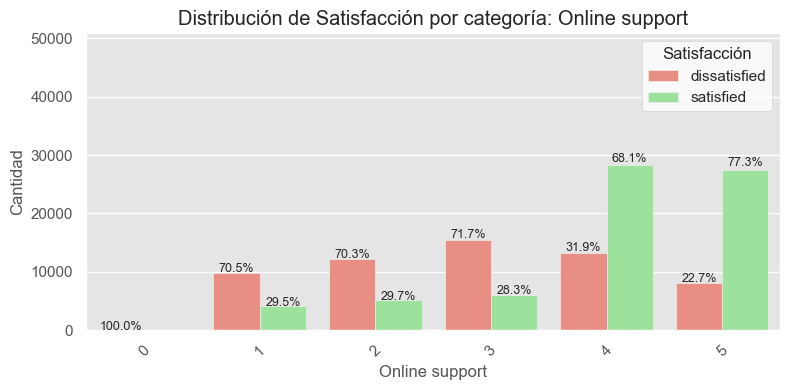

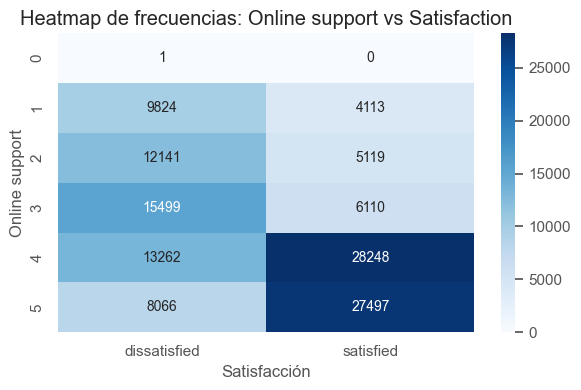


------------------------------------------------------------------------------------------------------------------------



In [60]:
# Definir variables ordinales
ordinal_vars = [
    'Inflight wifi service', 'Departure/Arrival time convenient',
    'Ease of Online booking', 'Gate location', 'Food and drink',
    'Online boarding', 'Seat comfort', 'Inflight entertainment',
    'On-board service', 'Leg room service', 'Baggage handling',
    'Checkin service', 'Cleanliness', 'Online support'
]

# Definir tipo categórico ordenado como texto
ordered_cat = CategoricalDtype(categories=['0', '1', '2', '3', '4', '5'], ordered=True)

# Convertir variables ordinales a string categórico ordenado
for var in ordinal_vars:
    df[var] = df[var].astype(str).astype(ordered_cat)

# Lista total de cualitativas
cat_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class'] + ordinal_vars
hue_order = ['dissatisfied', 'satisfied']

for var in cat_vars:
    # print(f"Distribución de satisfacción por '{var}'")
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(data=df, x=var, hue='satisfaction', palette=['salmon', 'lightgreen'], hue_order=hue_order)

    plt.title(f"Distribución de Satisfacción por categoría: {var}")
    plt.xlabel(var)
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45)
    legend = plt.legend(title='Satisfacción', loc='upper right')
    legend.get_frame().set_facecolor('white')

    # Calcular proporciones
    group_counts = df.groupby([var, 'satisfaction'], observed=True).size().unstack(fill_value=0)
    group_percents = group_counts.div(group_counts.sum(axis=1), axis=0)

    # Agregar porcentaje sobre cada barra
    for i, bars in enumerate(ax.containers):
        for bar in bars:
            height = bar.get_height()
            if height == 0:
                continue
            x_pos = bar.get_x() + bar.get_width() / 2
            try:
                label_idx = int(round(x_pos))
                category_label = ax.get_xticklabels()[label_idx].get_text()
                satisfaction = hue_order[i]
                pct = group_percents.loc[category_label, satisfaction]
                ax.text(x_pos, height + 0.02 * height, f'{pct:.1%}', ha='center', fontsize=9)
            except Exception as e:
                print(f"Error al anotar barra: {e}")
                continue

    # Ajustar espacio vertical
    max_height = max([bar.get_height() for bar in ax.patches])
    ax.set_ylim(0, max_height * 1.8)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6)  # Espacio extra entre plots
    plt.show()
    print("\n"*2)

    # Mostrar tabla de frecuencias debajo del gráfico
    freq_table = (pd.crosstab(df[var], df['satisfaction']))
    # print(pd.crosstab(df[var], df['satisfaction']))
    plt.figure(figsize=(6, 4))
    sns.heatmap(freq_table, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Heatmap de frecuencias: {var} vs Satisfaction")
    plt.xlabel("Satisfacción")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()
    print("\n" + "-"*120 + "\n")

### Análisis de variables cualitativas

A partir de los gráficos de barras y mapas de calor, que muestran la distribución de pasajeros según su nivel de satisfacción en cada categoría, podemos idenfiticar patrones relevantes en la relación entre variables y satisfacción del cliente.

### Principales observaciones:

- **Gender**:
  - Las mujeres presentan una mayor proporción de satisfacción (65.1%) comparado con los hombres (44%).
  - Esto indica una percepción más positiva del servicio por parte de pasajeras mujeres.

- **Customer Type**:
  - Los clientes leales ("Loyal Customers") tienen una proporción considerablemente más alta de satisfacción (61.6%) respecto a los no leales (24%).

- **Type of Travel**:
  - Los viajes de negocios están asociados con un mayor nivel de satisfacción (58.4%) en comparación con los viajes personales (46.6%).

- **Class**:
  - La clase Business muestra la mayor proporción de satisfacción (70.9%), seguida de Eco Plus (42.7%) y Económica (39.4%).
  - Hay una clara correlación entre el tipo de clase y la satisfacción del pasajero, lo que sugiere que la experiencia a bordo impacta fuertemente en la percepción del viaje.

### Servicios a bordo:

En general, para las siguientes variables ordinales (de 0 a 5), se observa que **a mayor puntuación otorgada, mayor es el porcentaje de satisfacción**. Este patrón es claro y consistente:

- **Inflight wifi service**
- **Ease of Online booking**
- **Gate location**
- **Food and drink**
- **Online boarding**
- **Departure/Arrival time convenient**

Este comportamiento indica que los pasajeros que califican mejor estos aspectos del servicio tienden a estar más satisfechos con su experiencia global. Además, se observa que una calificación de 5 (máxima) suele estar asociada con **niveles de satisfacción superiores al 65-75%**, mientras que puntuaciones bajas están dominadas por pasajeros insatisfechos.

---

## Correlación entre variables categóricas y satisfacción

Para analizar la relación entre la variable de satisfacción (`satisfaction`) y el resto de las variables categóricas, utilizamos el coeficiente **V de Cramér** o **Cramér’s V**.

Este método mide la fuerza de asociación entre dos variables categóricas, con valores entre:

- `0`: sin asociación
- `1`: asociación perfecta

A continuación, se calcula la V de Cramer para cada variable categórica respecto a `satisfaction`, y se muestran los resultados ordenados de mayor a menor.

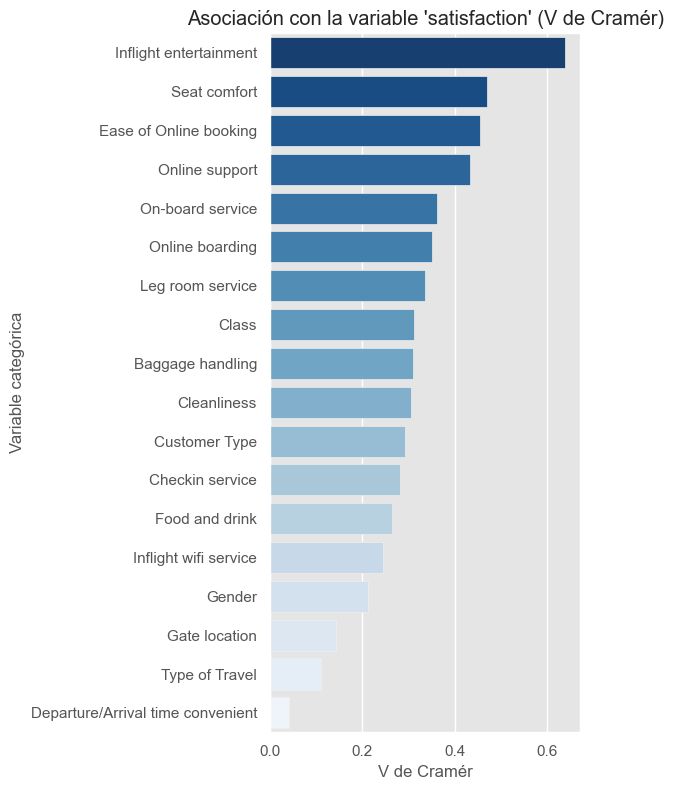

,V de Cramer
Inflight entertainment,0.639807
Seat comfort,0.469917
Ease of Online booking,0.454189
Online support,0.433028
On-board service,0.361474
Online boarding,0.350429
Leg room service,0.335844
Class,0.312330
Baggage handling,0.310289
Cleanliness,0.304823


In [61]:

# Función para calcular V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Corregimos el sesgo en caso de tablas grandes
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

# Variables categóricas a comparar con 'satisfaction'
cat_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class'] + ordinal_vars

# Calculamos V de Cramer para cada variable
cramer_results = {
    var: cramers_v(df[var], df['satisfaction']) for var in cat_vars
}

# Mostramos resultados ordenados
cramer_df = pd.DataFrame.from_dict(cramer_results, orient='index', columns=['V de Cramer'])
cramer_df = cramer_df.sort_values(by="V de Cramer", ascending=False)

# Mostrar
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 8))
sns.barplot(
    data=cramer_df.reset_index(),
    y='index',
    x="V de Cramer",
    hue='index',
    palette='Blues_r',
    dodge=False
)
plt.title("Asociación con la variable 'satisfaction' (V de Cramér)")
plt.xlabel("V de Cramér")
plt.ylabel("Variable categórica")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

# Mostrar también la tabla
cramer_df

### Conclusión del análisis:

En base a los valores de V de Cramér, clasificamos las variables en función de su nivel de asociación con la satisfacción:

#### Alta utilidad predictiva (V > 0.30)
Variables con una fuerte relación con la satisfacción.

- `Inflight entertainment`
- `Seat comfort`
- `Ease of Online booking`
- `Online support`
- `On-board service`
- `Online boarding`
- `Leg room service`
- `Class`
- `Baggage handling`
- `Cleanliness`

#### Utilidad moderada (V entre 0.20 y 0.30)
La relación de estas variables con la satisfacción es menos directa:

- `Customer Type`
- `Checkin service`
- `Food and drink`
- `Inflight wifi service`
- `Gender`

#### Baja utilidad (V < 0.20)
Estas variables muestran muy poca relación con la satisfacción:

- `Gate location`
- `Type of Travel`
- `Departure/Arrival time convenient`




---

## Variables numéricas

Además de las variables categóricas, nuestro dataset contiene las siguientes variables numéricas:
- `Age`
- `Flight Distance`
- `Departure Delay in Minutes`
- `Arrival Delay in Minutes`

### Boxplots por nivel de satisfacción

Para cada variable, utilizamos **boxplots** que permiten observar la dispersión, la mediana y la presencia de valores atípicos, comparando las distribuciones entre pasajeros satisfechos y no satisfechos.

### Distribución general de variables numéricas

Para comenzar con el análisis exploratorio de las variables numéricas, se generaron histogramas con curva de densidad (KDE) para observar su **distribución general**. Este tipo de visualización permite identificar:

- Si las variables tienen una distribución simétrica o presentan sesgos.
- La existencia de múltiples picos o modos (distribuciones multimodales).
- La concentración o dispersión de los datos.

Este análisis **univariado** brinda una primera aproximación sobre el comportamiento de cada variable de forma global, sin segmentar por niveles de satisfacción.

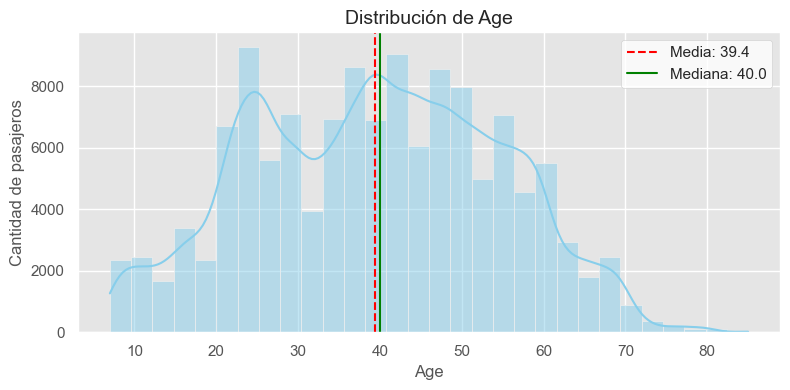

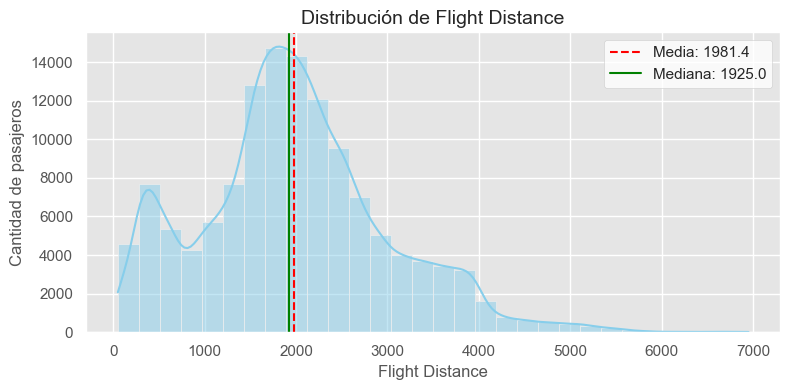

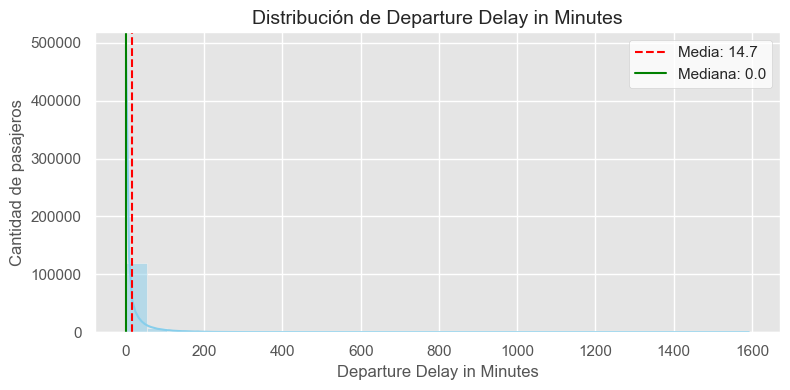

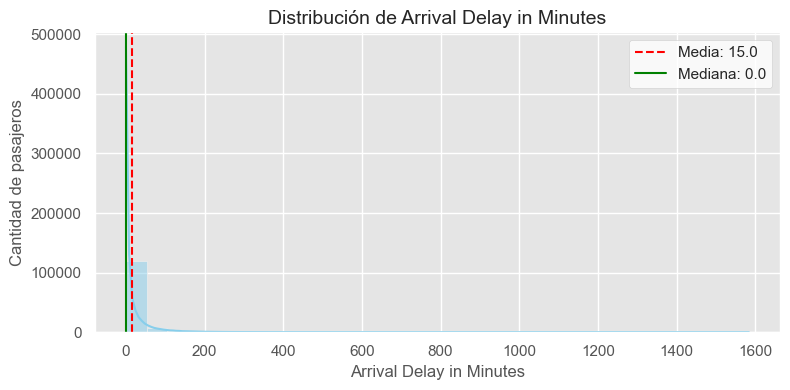

In [62]:
# Visualización de la distribución general con histogramas
num_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

for var in num_vars:
    plt.figure(figsize=(8, 4))

    # Histograma con curva de densidad
    sns.histplot(df[var], bins=30, kde=True, color='skyblue')

    # Calcular media y mediana
    mean_val = df[var].mean()
    median_val = df[var].median()

    # Dibujar líneas verticales
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.1f}')

    plt.title(f'Distribución de {var}', fontsize=14)
    plt.xlabel(var)
    plt.ylabel('Cantidad de pasajeros')
    legend = plt.legend()
    legend.get_frame().set_facecolor('white')
    plt.tight_layout()
    plt.show()

### Comparación de variables numéricas según nivel de satisfacción

Como complemento al análisis univariado, se realizaron boxplots para comparar la distribución de cada variable numérica según el nivel de satisfacción del pasajero.

Este análisis **bivariado** permite:

- Detectar diferencias significativas entre pasajeros satisfechos y no satisfechos.
- Visualizar la dispersión, presencia de valores atípicos y mediana en cada grupo.
- Identificar patrones que podrían estar relacionados con la experiencia del cliente.

De esta forma, se busca entender cómo varía el comportamiento de cada variable en función de la satisfacción reportada.

,mean,median,std
satisfaction,,,
dissatisfied,37.47,36.00,15.89
satisfied,41.05,42.00,14.25


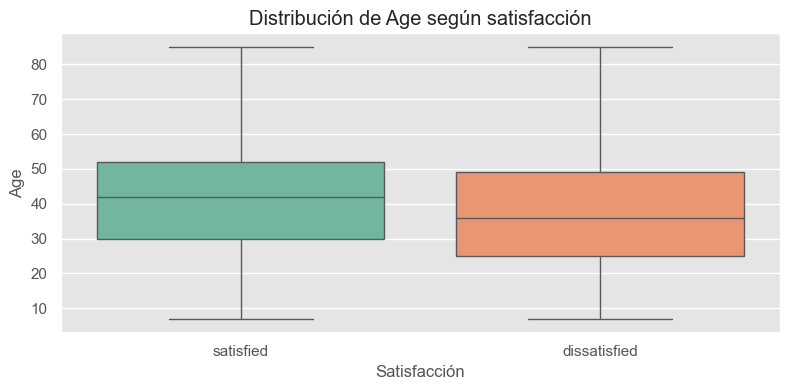


------------------------------------------------------------------------------------------------------------------------



,mean,median,std
satisfaction,,,
dissatisfied,2025.71,1955.00,888.15
satisfied,1944.77,1886.00,1127.89


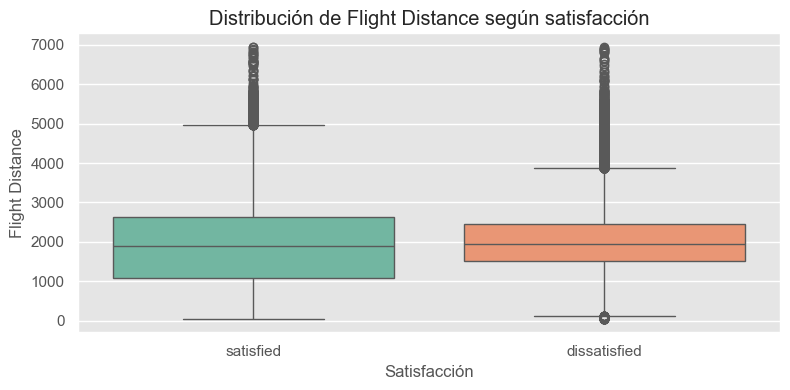


------------------------------------------------------------------------------------------------------------------------



,mean,median,std
satisfaction,,,
dissatisfied,17.81,0.00,43.51
satisfied,12.15,0.00,32.68


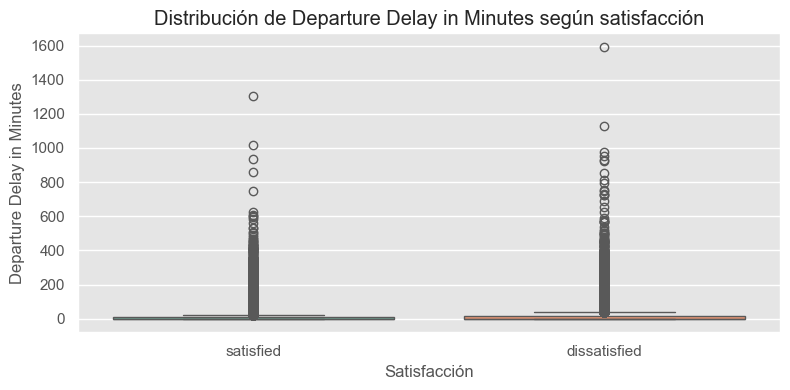


------------------------------------------------------------------------------------------------------------------------



,mean,median,std
satisfaction,,,
dissatisfied,18.45,0.00,43.79
satisfied,12.23,0.00,33.06


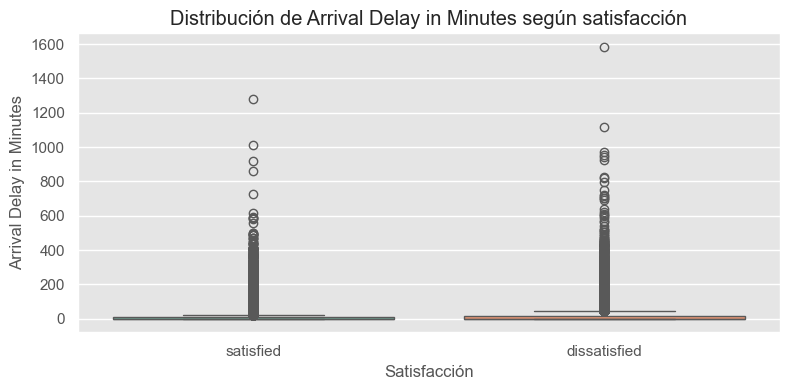


------------------------------------------------------------------------------------------------------------------------



In [63]:
num_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

for var in num_vars:
    # Mostrar estadísticas por grupo
    stats = df.groupby('satisfaction')[var].agg(['mean', 'median', 'std']).round(2)

    styled_stats = (
        stats.style
        .set_caption(f"Estadísticas de '{var}' por nivel de satisfacción")
        .format("{:.2f}")
        .background_gradient(cmap='Blues', axis=None)
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('color', 'black'),
                ('font-size', '14px'),
                ('text-align', 'center'),
                ('font-weight', 'bold')]}
        ])
    )
    display(styled_stats)

    # Graficar boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='satisfaction', y=var, hue='satisfaction', palette='Set2', legend=False)
    plt.title(f'Distribución de {var} según satisfacción')
    plt.xlabel('Satisfacción')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()
    print("\n"*1 + "--"*60 + "\n"*1)

### Proporción de satisfacción por rango de distancia del vuelo

Para complementar los análisis anteriores sobre la variable `Flight Distance`, se agruparon los datos en rangos (buckets) y se graficó la **proporción de pasajeros satisfechos e insatisfechos** dentro de cada rango de distancia.

Este tipo de gráfico permite observar la evolución de la satisfacción según el tipo de vuelo (corto, medio, largo), lo cual **no se refleja de forma clara en los histogramas ni boxplots**.

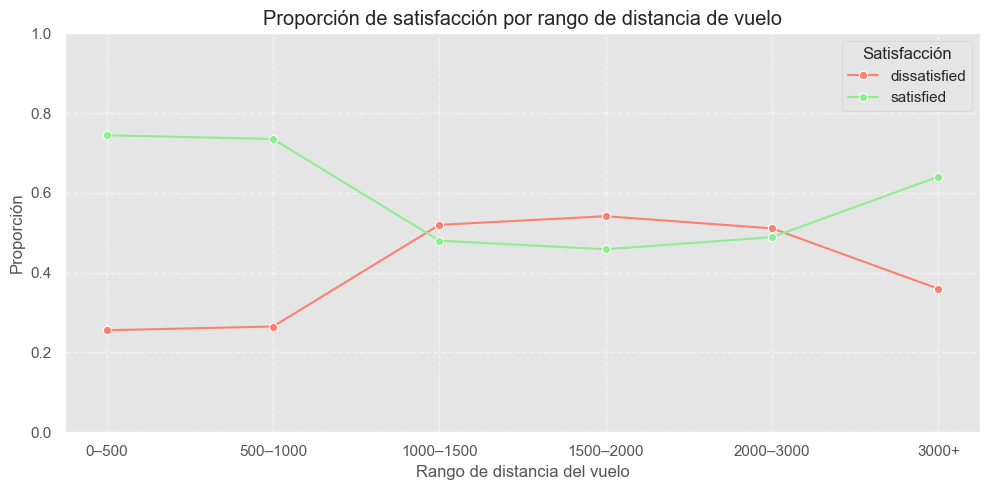

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear buckets de distancia
bins = [0, 500, 1000, 1500, 2000, 3000, df['Flight Distance'].max()]
labels = ['0–500', '500–1000', '1000–1500', '1500–2000', '2000–3000', '3000+']
df['Flight Distance Bucket'] = pd.cut(df['Flight Distance'], bins=bins, labels=labels, include_lowest=True)

# Asegurar orden correcto en el eje x
df['Flight Distance Bucket'] = pd.Categorical(df['Flight Distance Bucket'], categories=labels, ordered=True)

# Agrupar y calcular proporciones
grouped = df.groupby(['Flight Distance Bucket', 'satisfaction'], observed=True).size().reset_index(name='count')
grouped['proportion'] = grouped.groupby('Flight Distance Bucket', observed=True)['count'].transform(lambda x: x / x.sum())

# Graficar
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=grouped,
    x='Flight Distance Bucket',
    y='proportion',
    hue='satisfaction',
    marker='o',
    palette=['salmon', 'lightgreen']
)
plt.title('Proporción de satisfacción por rango de distancia de vuelo')
plt.xlabel('Rango de distancia del vuelo')
plt.ylabel('Proporción')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Satisfacción')
plt.tight_layout()
plt.show()

### Proporción de satisfacción por rango de demora (salida y llegada)

Para profundizar el análisis de las variables `Departure Delay in Minutes` y `Arrival Delay in Minutes`, se agruparon los datos en rangos de minutos (buckets) y se graficó la **proporción de pasajeros satisfechos e insatisfechos** dentro de cada rango de demora.

Este enfoque permite observar cómo evoluciona la satisfacción a medida que aumentan los tiempos de espera.

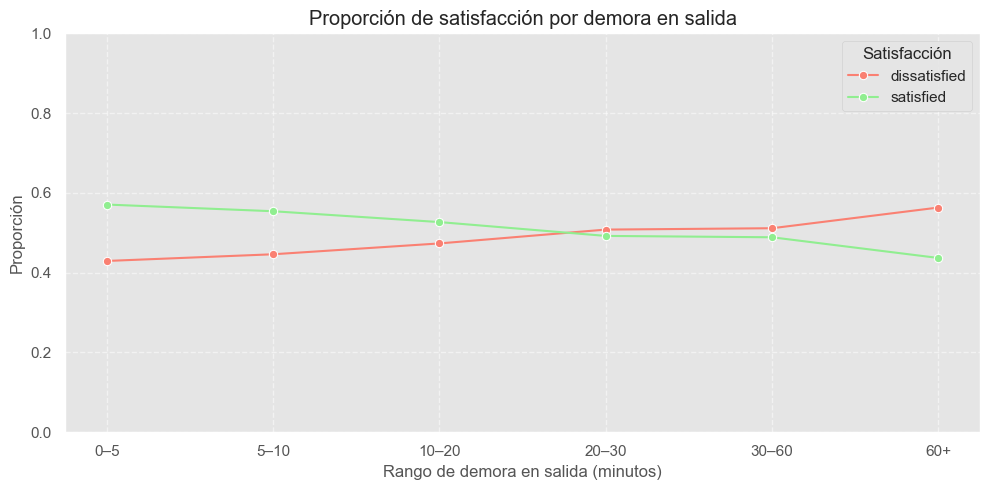

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear buckets de demora en salida
bins = [0, 5, 10, 20, 30, 60, df['Departure Delay in Minutes'].max()]
labels = ['0–5', '5–10', '10–20', '20–30', '30–60', '60+']
df['Departure Delay Bucket'] = pd.cut(df['Departure Delay in Minutes'], bins=bins, labels=labels, include_lowest=True)
df['Departure Delay Bucket'] = pd.Categorical(df['Departure Delay Bucket'], categories=labels, ordered=True)

# Agrupar y calcular proporciones
grouped_dep = df.groupby(['Departure Delay Bucket', 'satisfaction'], observed=True).size().reset_index(name='count')
grouped_dep['proportion'] = grouped_dep.groupby('Departure Delay Bucket', observed=True)['count'].transform(lambda x: x / x.sum())

# Graficar
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=grouped_dep,
    x='Departure Delay Bucket',
    y='proportion',
    hue='satisfaction',
    marker='o',
    palette=['salmon', 'lightgreen']
)
plt.title('Proporción de satisfacción por demora en salida')
plt.xlabel('Rango de demora en salida (minutos)')
plt.ylabel('Proporción')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Satisfacción')
plt.tight_layout()
plt.show()

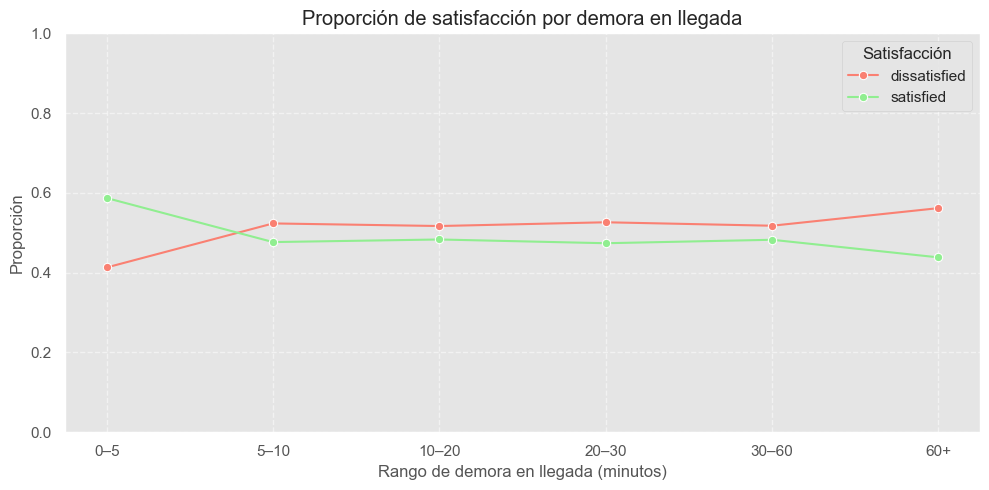

In [66]:
# Crear buckets de demora en llegada
bins = [0, 5, 10, 20, 30, 60, df['Arrival Delay in Minutes'].max()]
labels = ['0–5', '5–10', '10–20', '20–30', '30–60', '60+']
df['Arrival Delay Bucket'] = pd.cut(df['Arrival Delay in Minutes'], bins=bins, labels=labels, include_lowest=True)
df['Arrival Delay Bucket'] = pd.Categorical(df['Arrival Delay Bucket'], categories=labels, ordered=True)

# Agrupar y calcular proporciones
grouped_arr = df.groupby(['Arrival Delay Bucket', 'satisfaction'], observed=True).size().reset_index(name='count')
grouped_arr['proportion'] = grouped_arr.groupby('Arrival Delay Bucket', observed=True)['count'].transform(lambda x: x / x.sum())

# Graficar
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=grouped_arr,
    x='Arrival Delay Bucket',
    y='proportion',
    hue='satisfaction',
    marker='o',
    palette=['salmon', 'lightgreen']
)
plt.title('Proporción de satisfacción por demora en llegada')
plt.xlabel('Rango de demora en llegada (minutos)')
plt.ylabel('Proporción')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Satisfacción')
plt.tight_layout()
plt.show()

## Conclusiones del análisis de variables numéricas

### Edad (`Age`)

- La distribución general es ligeramente asimétrica hacia la derecha, con la mayoría de los pasajeros entre los 30 y 50 años.
- Al segmentar por satisfacción, se observa que los pasajeros satisfechos tienden a ser mayores(media ≈ 41 años) respecto a los insatisfechos (media ≈ 37 años).
- Esto sugiere que la **edad puede tener una leve influencia positiva en la percepción del servicio**.



###  Distancia del vuelo (`Flight Distance`)

- La distribución presenta una forma multimodal, con picos marcados en ciertos rangos y una larga cola derecha, debido a vuelos excepcionalmente largos.
- A nivel general, la diferencia entre satisfechos e insatisfechos en términos de distancia no parece significativa, ya que sus medias y medianas son similares.
- Sin embargo, con el análisis por rangos de distancia se puede observar:
  - **Mayor proporción de satisfacción** en vuelos **cortos (< 1000)** y **muy largos (> 3000)**.
  - **Mayor proporción de insatisfacción** en vuelos de **distancia media (1000–3000)**.
- Esto indica que **la distancia del vuelo podría tener un efecto no lineal sobre la satisfacción**, posiblemente mediado por expectativas según el tipo de vuelo (ej.: entretenimiento, comodidad, puntualidad).

### Demora en la salida (`Departure Delay in Minutes`)

- Distribución fuertemente sesgada a la derecha, con la mayoría de los vuelos sin demora pero presencia de valores extremos.
- Los pasajeros insatisfechos tienen mayor demora promedio (≈ 17.8 min) que los satisfechos (≈ 12.1 min), aunque la mediana es 0 para ambos.
- A medida que aumenta la demora, la proporción de pasajeros insatisfechos también crece, especialmente a partir de los 30 minutos, donde la insatisfacción supera ampliamente a la satisfacción.

### Demora en la llegada (`Arrival Delay in Minutes`)

- Distribución similar a la anterior, también con fuerte asimetría positiva.
- Nuevamente, se observa mayor demora promedio en los pasajeros insatisfechos (≈ 18.4 min vs 12.2 min).
- La proporción de satisfacción cae visiblemente cuando la demora supera los 5 minutos, y se mantiene por debajo de la insatisfacción en todos los tramos posteriores.

## Análisis de relaciones entre variables

Además de estudiar cómo cada variable se relaciona con la satisfacción, también analizamos las relaciones entre las propias variables del dataset.

Este análisis nos permite:
- Detectar **variables redundantes** que aportan información similar.
- Identificar posibles **interacciones** entre variables que podrían influir conjuntamente en la satisfacción.
- Comprender mejor cómo se estructuran los datos y cómo podrían agruparse o correlacionarse ciertos atributos.

Entonces, se analizan las relaciones entre variables mediante distintos enfoques según el tipo de variable:

- **Ordinales entre sí**: utilizamos **mapas de calor de correlación** para ver si las puntuaciones en distintos servicios tienden a moverse juntas.
- **Categóricas entre sí**: analizamos **tablas de contingencia y heatmaps** para detectar patrones de agrupamiento.

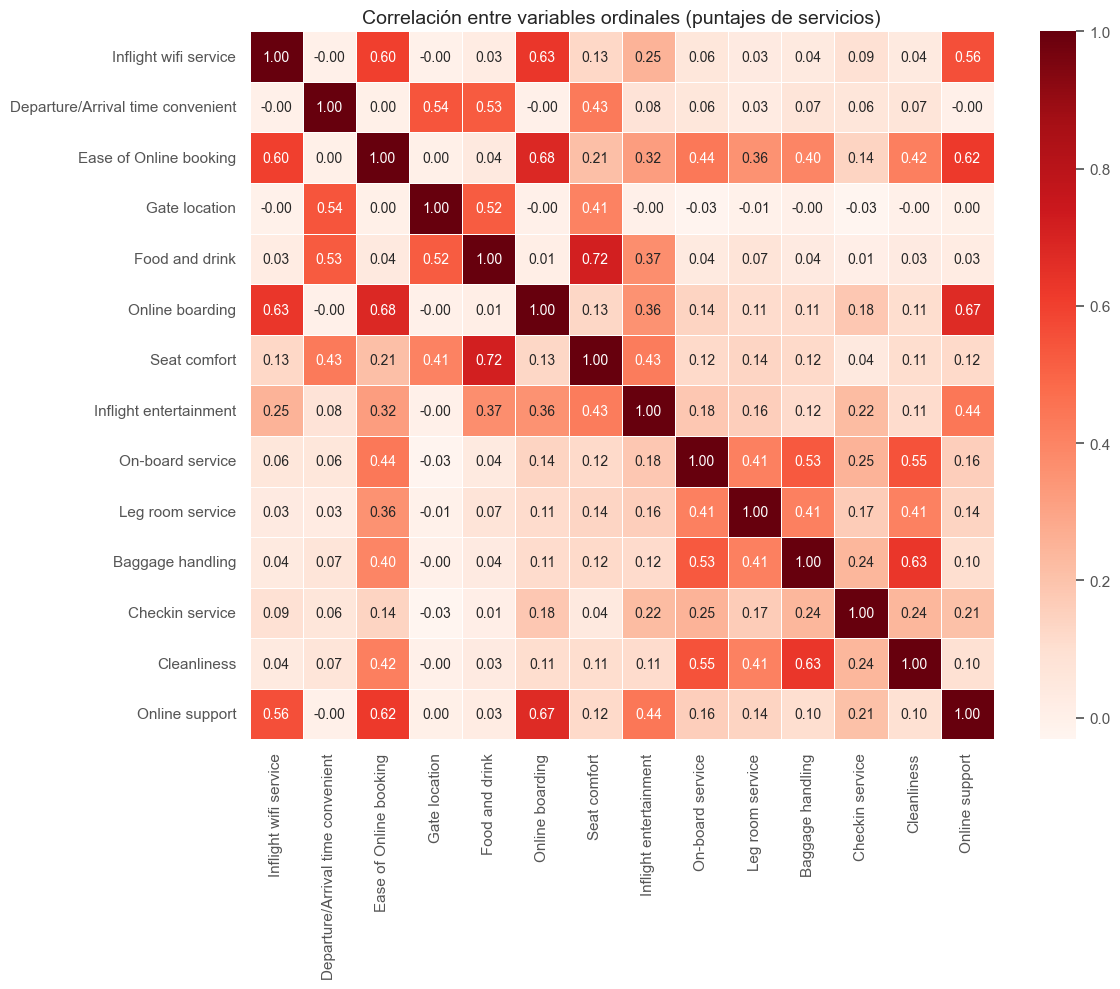

In [67]:
# Seleccionamos solo las columnas ordinales
ordinal_vars = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
    'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
    'Cleanliness', 'Online support'
]

# Convertimos a numérico para calcular correlaciones
df_ordinal = df[ordinal_vars].apply(pd.to_numeric, errors='coerce')

# Calculamos matriz de correlación
corr_matrix = df_ordinal.corr()

# Plot del heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="Reds", fmt=".2f", linewidths=.5)
plt.title("Correlación entre variables ordinales (puntajes de servicios)", fontsize=14)
plt.tight_layout()
plt.show()

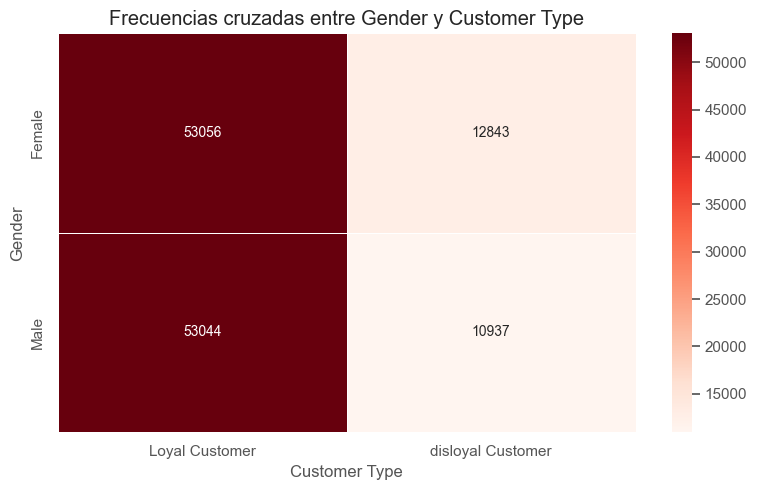

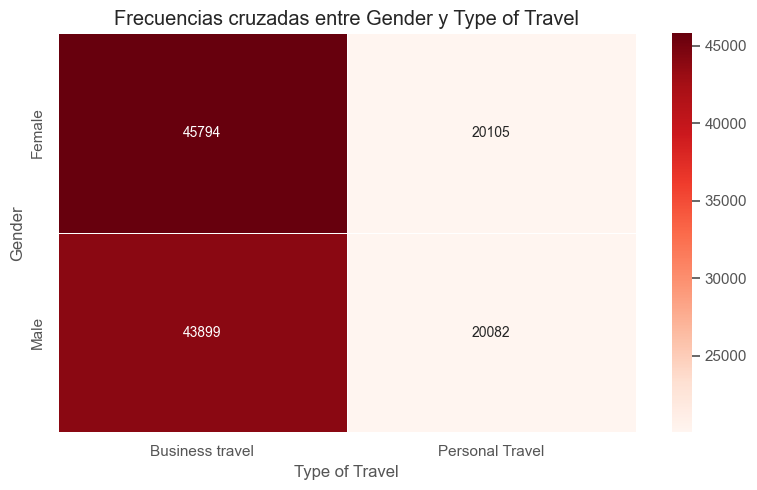

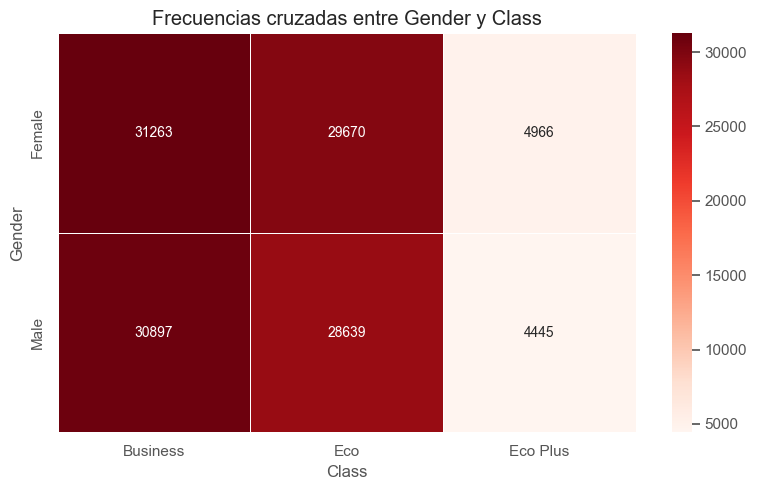

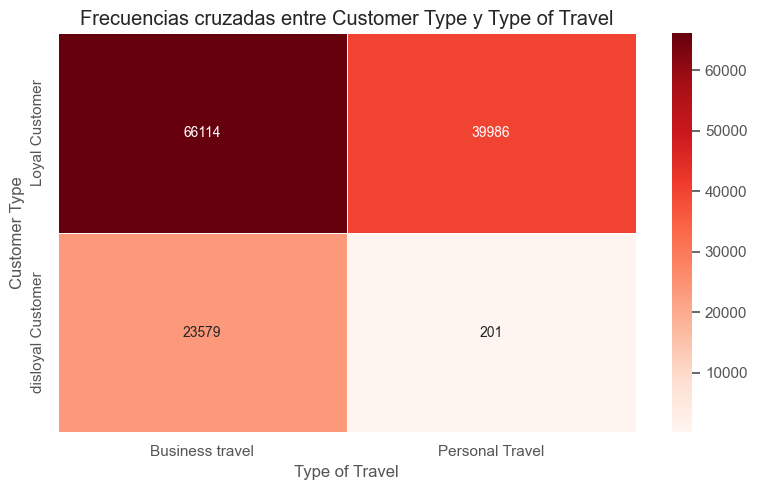

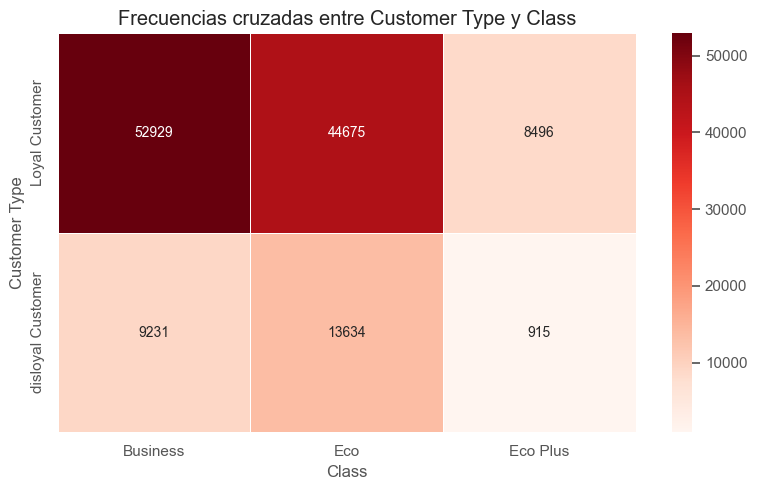

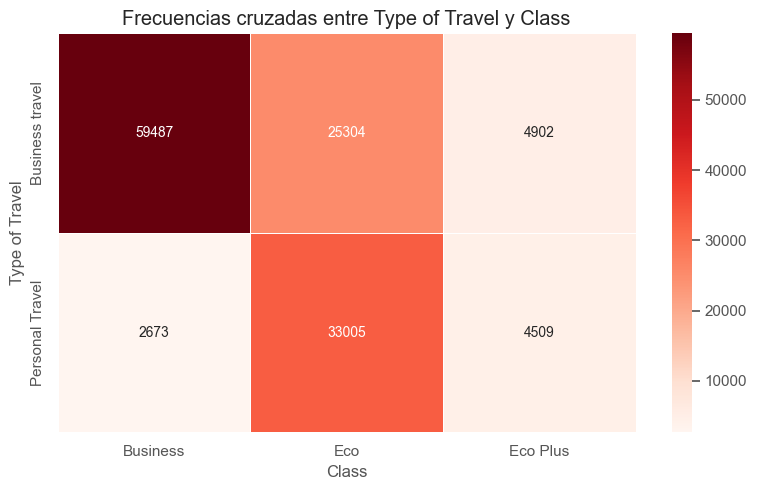

In [68]:
# Categóricas para comparar entre si
cat_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

for var1, var2 in combinations(cat_vars, 2):
    ct = pd.crosstab(df[var1], df[var2])
    plt.figure(figsize=(8, 5))
    sns.heatmap(ct, annot=True, cmap="Reds", fmt="d", linewidths=.5)
    plt.title(f"Frecuencias cruzadas entre {var1} y {var2}")
    plt.xlabel(var2)
    plt.ylabel(var1)
    plt.tight_layout()
    plt.show()

## Conclusiones del análisis entre variables


### Correlación entre variables ordinales (servicios puntuados)

A través de una matriz de correlación entre los servicios puntuados de 0 a 5, identificamos algunas asociaciones destacadas:

- Existe **alta correlación positiva** entre:
  - `Seat comfort` y `Food and drink` (0.72)
  - `Seat comfort` y `Cleanliness` (0.63)
  - `Online boarding` y `Ease of Online booking` (0.68)
  - `Online support` y `Ease of Online booking` (0.62)
- También se observa una relación entre `Leg room service`, `Seat comfort`, `On-board service` y `Cleanliness`.



### Frecuencias cruzadas entre variables categóricas

Analizamos combinaciones entre variables categóricas clave a través de mapas de calor de conteos, observando:

- **Customer Type vs Type of Travel**:
  - La gran mayoría de clientes leales realiza viajes de negocios.
  - Los clientes desleales casi exclusivamente hacen viajes personales.

- **Class vs Type of Travel**:
  - Los viajeros de negocios tienden a volar más en **Business o Eco Plus**, mientras que los viajeros personales se concentran en **Eco Class**.

- **Customer Type vs Class**:
  - Los clientes leales tienen mayor presencia en clases superiores.
  - Los desleales vuelan principalmente en económica, con escasa representación en Eco Plus.

- **Gender**:
  - La distribución por género es **muy pareja** en todas las combinaciones observadas (Tipo de viaje, Clase, Tipo de cliente), por lo que **no parece haber sesgo de género en estos aspectos**.
---